In [1]:
!pip install feature-engine
!pip install holidays

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 328.9/328.9 kB 3.0 MB/s eta 0:00:00


In [2]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df = pd.read_excel("/content/drive/MyDrive/dataset.xlsx")
df

,Unnamed: 0,date,sales
0,0,2013-01-01,13
1,1,2013-01-02,11
2,2,2013-01-03,14
3,3,2013-01-04,13
4,4,2013-01-05,10
...,...,...,...
1821,1821,2017-12-27,14
1822,1822,2017-12-28,19
1823,1823,2017-12-29,15
1824,1824,2017-12-30,27


In [5]:
df.drop(columns=df.columns[0], axis=1, inplace=True)

In [6]:
date_time = pd.DataFrame(df['date'])

In [7]:
df['date'] = df['date'].astype(str) + ' 00:00:00'

In [8]:
df.head()

,date,sales
0,2013-01-01 00:00:00,13
1,2013-01-02 00:00:00,11
2,2013-01-03 00:00:00,14
3,2013-01-04 00:00:00,13
4,2013-01-05 00:00:00,10


In [9]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
sales,1826.0,19.971522,6.741022,4.0,15.0,19.0,24.0,50.0


In [10]:
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

In [11]:
from feature_engine.creation import CyclicalFeatures
from feature_engine.datetime import DatetimeFeatures

def dateTimeToSignal(df):
    '''
    Converts the DateTime index to timestamp and converts it to signal (sine and cosine) to deal with periodicity.
    Input:
        df: DataFrame with a DateTime index
    Output:
        df: DataFrame with additional columns representing Sin/Cosine signals for timestamp, month, day, week, and year
    '''
    # Ensure the index is a datetime object
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index)

    timestamp_s = df.index.map(datetime.datetime.timestamp)
    day = 24 * 60 * 60
    week = 7 * day
    year = 365.2425 * day

    # Extract month and day components
    df['Month'] = df.index.month
    df['Day_of_month'] = df.index.day

    # Apply cyclical features transformer to month and day columns
    cyclical_transformer = CyclicalFeatures(
        variables=['Month', 'Day_of_month'],  # specify the variable to transform
        drop_original=True  # drop the original variables
    )

    df = cyclical_transformer.fit_transform(df)

    df['Week sin'] = np.sin(2 * np.pi * timestamp_s / week)
    df['Week cos'] = np.cos(2 * np.pi * timestamp_s / week)

    df['Year sin'] = np.sin(2 * np.pi * timestamp_s / year)
    df['Year cos'] = np.cos(2 * np.pi * timestamp_s / year)

    return df



In [12]:
df = dateTimeToSignal(df)

In [13]:
df

,sales,Month_sin,Month_cos,Day_of_month_sin,Day_of_month_cos,Week sin,Week cos,Year sin,Year cos
date,,,,,,,,,
2013-01-01,13,5.000000e-01,0.866025,2.012985e-01,0.979530,-9.749279e-01,-0.222521,0.009848,0.999952
2013-01-02,11,5.000000e-01,0.866025,3.943559e-01,0.918958,-7.818315e-01,0.623490,0.027048,0.999634
2013-01-03,14,5.000000e-01,0.866025,5.712682e-01,0.820763,-1.801393e-13,1.000000,0.044240,0.999021
2013-01-04,13,5.000000e-01,0.866025,7.247928e-01,0.688967,7.818315e-01,0.623490,0.061418,0.998112
2013-01-05,10,5.000000e-01,0.866025,8.486443e-01,0.528964,9.749279e-01,-0.222521,0.078579,0.996908
...,...,...,...,...,...,...,...,...,...
2017-12-27,14,-2.449294e-16,1.000000,-7.247928e-01,0.688967,-7.818315e-01,0.623490,-0.079736,0.996816
2017-12-28,19,-2.449294e-16,1.000000,-5.712682e-01,0.820763,5.804087e-13,1.000000,-0.062577,0.998040
2017-12-29,15,-2.449294e-16,1.000000,-3.943559e-01,0.918958,7.818315e-01,0.623490,-0.045400,0.998969


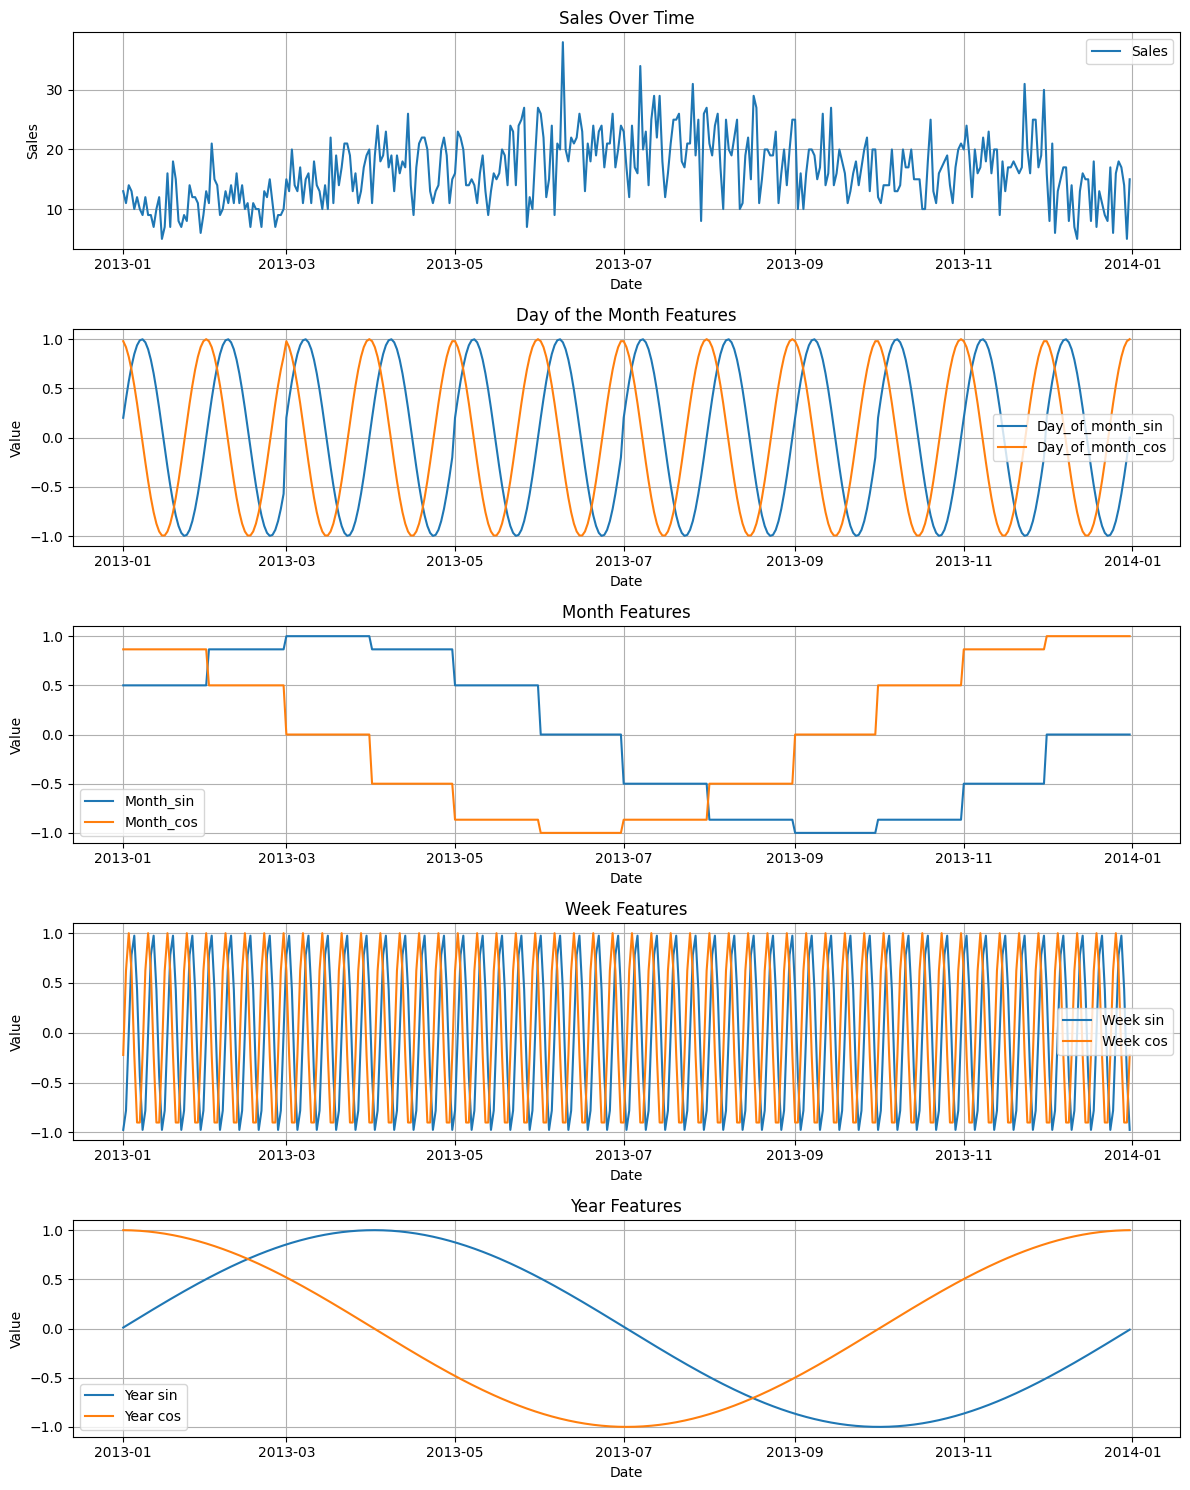

In [14]:
import matplotlib.pyplot as plt

# Create a figure with subplots
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(12, 15))

# Select a subset of the data based on the number of rows to display
subset_df = df.iloc[:365,]

# Plot the sales over time
axes[0].plot(subset_df.index, subset_df['sales'], label='Sales')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Sales')
axes[0].set_title('Sales Over Time')
axes[0].legend()
axes[0].grid(True)

# Plot the sine and cosine features for day of the month
axes[1].plot(subset_df.index, subset_df['Day_of_month_sin'], label='Day_of_month_sin')
axes[1].plot(subset_df.index, subset_df['Day_of_month_cos'], label='Day_of_month_cos')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Value')
axes[1].set_title('Day of the Month Features')
axes[1].legend()
axes[1].grid(True)

# Plot the sine and cosine features for month
axes[2].plot(subset_df.index, subset_df['Month_sin'], label='Month_sin')
axes[2].plot(subset_df.index, subset_df['Month_cos'], label='Month_cos')
axes[2].set_xlabel('Date')
axes[2].set_ylabel('Value')
axes[2].set_title('Month Features')
axes[2].legend()
axes[2].grid(True)

# Plot the sine and cosine features for week
axes[3].plot(subset_df.index, subset_df['Week sin'], label='Week sin')
axes[3].plot(subset_df.index, subset_df['Week cos'], label='Week cos')
axes[3].set_xlabel('Date')
axes[3].set_ylabel('Value')
axes[3].set_title('Week Features')
axes[3].legend()
axes[3].grid(True)

# Plot the sine and cosine features for year
axes[4].plot(subset_df.index, subset_df['Year sin'], label='Year sin')
axes[4].plot(subset_df.index, subset_df['Year cos'], label='Year cos')
axes[4].set_xlabel('Date')
axes[4].set_ylabel('Value')
axes[4].set_title('Year Features')
axes[4].legend()
axes[4].grid(True)

# Adjust subplot spacing
plt.tight_layout()

# Display the plots
plt.show()


In [16]:
import holidays
from datetime import date

bd_holidays = holidays.BD()

def is_holiday(date):
    # Ensure the date is in the correct format (date object)
    if isinstance(date, str):
        date = date.fromisoformat(date)
    return int(date in bd_holidays)

In [21]:
df['is_holiday'] = df.index.map(is_holiday)
df['is_holiday']

date
2013-01-01    0
2013-01-02    0
2013-01-03    0
2013-01-04    0
2013-01-05    0
             ..
2017-12-27    0
2017-12-28    0
2017-12-29    0
2017-12-30    0
2017-12-31    0
Name: is_holiday, Length: 1826, dtype: int64

In [22]:
df.columns

Index(['sales', 'Month_sin', 'Month_cos', 'Day_of_month_sin',
       'Day_of_month_cos', 'Week sin', 'Week cos', 'Year sin', 'Year cos',
       'is_holiday'],
      dtype='object')

Most important frequencies:
Frequency: 0.002738225629791895, Period: 365.2 days
Frequency: 0.1429353778751369, Period: 6.996168582375479 days
Frequency: 0.000547645125958379, Period: 1826.0 days
Frequency: 0.2858707557502738, Period: 3.4980842911877397 days


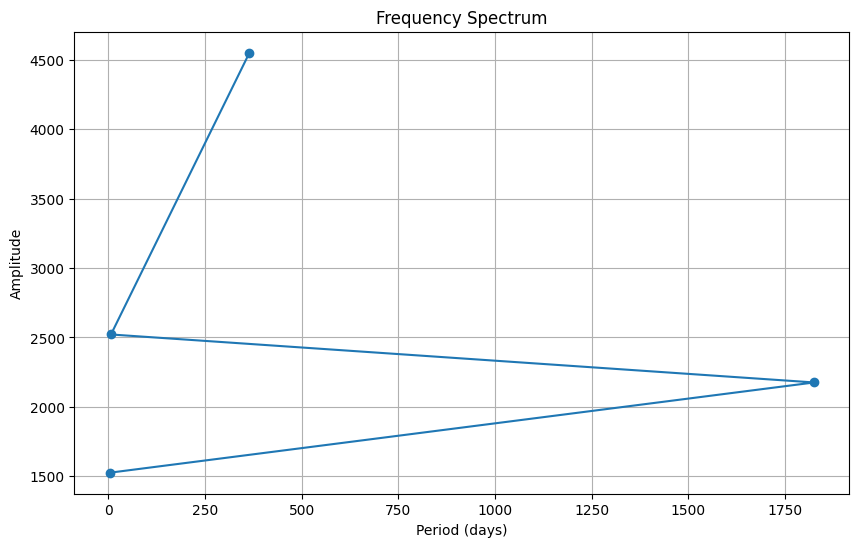

In [23]:
# Compute the FFT
sales_fft = np.fft.fft(df['sales'])

# Get the frequencies
n = len(df)
frequencies = np.fft.fftfreq(n)
positive_frequencies = frequencies[:n // 2]
amplitudes = np.abs(sales_fft[:n // 2])

# Find the most important frequencies
top_k = 5  # Number of top frequencies to display
top_indices = np.argsort(amplitudes)[::-1][:top_k]

# Plot the frequency spectrum, skipping the first frequency component
plt.figure(figsize=(10, 6))
plt.title("Frequency Spectrum")
plt.plot(1 / positive_frequencies[top_indices[1:]], amplitudes[top_indices[1:]], 'o-')
plt.xlabel("Period (days)")
plt.ylabel("Amplitude")
plt.grid(True)

# Show the most important frequencies, skipping the first one
print("Most important frequencies:")
for idx in top_indices[1:]:
    period = 1 / positive_frequencies[idx]
    print(f"Frequency: {positive_frequencies[idx]}, Period: {period} days")

# Display the plot
plt.show()

Here's an explanation of the output:

Frequency: 0.002738225629791895, Period: 365.2 days:

This frequency component corresponds to a period of approximately one year (365.2 days). It indicates a yearly seasonality in the sales data, suggesting that there is a repeating pattern or seasonality in the sales data with a one-year cycle, which is common in many businesses due to seasonal variations.
Frequency: 0.1429353778751369, Period: 6.996168582375479 days:

This frequency component corresponds to a period of approximately 7 days (6.996 days). It indicates a weekly seasonality in the sales data, suggesting that there is a repeating pattern or seasonality in the sales data with a one-week cycle. This may be related to weekly trends or behaviors in your data.
Frequency: 0.000547645125958379, Period: 1826.0 days:

This frequency component corresponds to a period of approximately 1826 days (about 5 years). It suggests a longer-term cycle or trend in the sales data that repeats every 5 years. This could be associated with macroeconomic or industry-specific factors.
Frequency: 0.2858707557502738, Period: 3.4980842911877397 days:

This frequency component corresponds to a period of approximately 3.5 days. It indicates a short-term cycle or seasonality in the sales data, possibly related to daily fluctuations or events affecting sales on a daily basis.


In summary, the FFT analysis reveals the underlying periodic components in your sales data, helping you understand the different time scales at which patterns and seasonality occur. These insights can be valuable for forecasting, trend analysis, and understanding the dynamics of your sales data.

In [25]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]
num_features

10

In [29]:
column_indices

{'sales': 0,
 'Month_sin': 1,
 'Month_cos': 2,
 'Day_of_month_sin': 3,
 'Day_of_month_cos': 4,
 'Week sin': 5,
 'Week cos': 6,
 'Year sin': 7,
 'Year cos': 8,
 'is_holiday': 9}

In [26]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

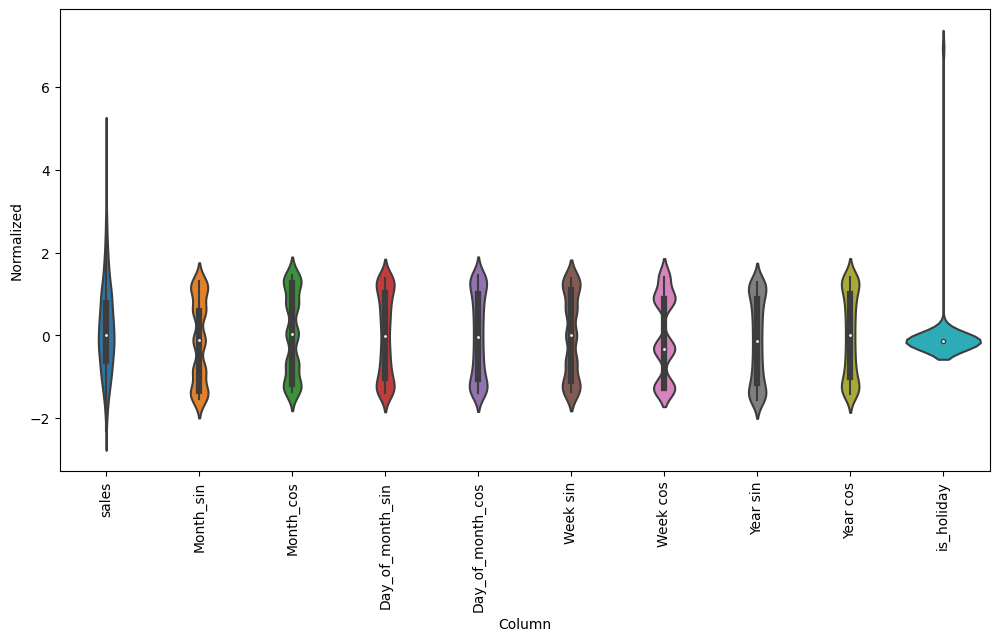

In [27]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

In [28]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [30]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24,
                     label_columns=['sales'])
w1

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [47]
Label column name(s): ['sales']

In [31]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['sales'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['sales']

In [32]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [33]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 10)
Inputs shape: (3, 6, 10)
Labels shape: (3, 1, 1)


In [36]:
w2.example = example_inputs, example_labels

In [41]:
def plot(self, model=None, plot_col='sales', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Period(day)')

WindowGenerator.plot = plot

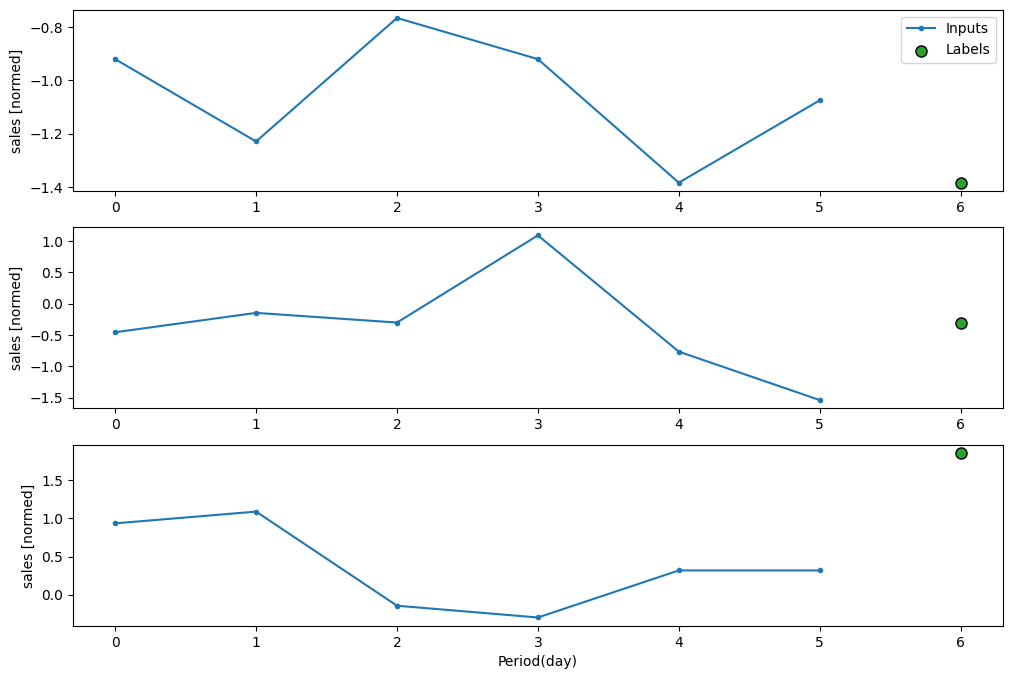

In [42]:
w2.plot()

In [43]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [44]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [45]:
# Each element is an (inputs, label) pair.
w2.train.element_spec

(TensorSpec(shape=(None, 6, 10), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [46]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['sales'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['sales']

In [47]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 10)
Labels shape (batch, time, features): (32, 1, 1)


In [53]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [54]:
baseline = Baseline(label_index=column_indices['sales'])

baseline.compile(loss=tf.keras.losses.MeanSquaredError(), metrics=[tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.RootMeanSquaredError(),
                          tf.keras.metrics.MeanAbsolutePercentageError(), tf.keras.metrics.MeanSquaredError()]
                 )

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

12/12 [==============================] - 0s 3ms/step - loss: 1.3443 - mean_absolute_error: 0.9309 - root_mean_squared_error: 1.1594 - mean_absolute_percentage_error: 529.9138 - mean_squared_error: 1.3443
